In [14]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

from gangen.cdcgan import Generator, Discriminator

In [15]:
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
data_dir = './data/archive2'
train_dir = os.path.join(data_dir, 'preprocessed', 'Train')

data_tf = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.08, 0.08), scale=(0.9, 1.1), shear=5),
    transforms.Resize((32, 32)),
    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
   
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),

    transforms.ToTensor(),

    transforms.RandomErasing(p=0.2, scale=(0.01, 0.04), ratio=(0.5, 2.0), value=0), # value=0 for black box

    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


full_dataset = datasets.ImageFolder(root = train_dir, transform=data_tf)

In [ ]:
# Hyperparameters
# batch_size = 64
# num_epochs = 200
# beta1 = 0.5
# beta2 = 0.999
# noise_dim = 100
# n_classes = 43
# embedding_dim = 64
# lambda_gp = 10

# k_steps_D = 2
# k_steps_G = 1 
# log_interval = 5  # Log images every N epochs
# checkpoint_interval = 10 # Save checkpoint every N epochs

# label_smoothing = 0.0
# learning_rate_g = 0.0001
# learning_rate_d = 0.00015

#tanay's hyperparmeters below
# Core
batch_size = 128        # More stable gradients, better batch norm stats
num_epochs = 400        # GTSRB is diverse, needs longer training

# Optimizer betas
beta1 = 0.0             # Helps prevent mode collapse (as per WGAN-GP)
beta2 = 0.99            # Slower, more stable Adam convergence

# Noise and class setup
noise_dim = 128         # Slightly higher, allows richer generation
n_classes = 43
embedding_dim = 128     # Larger embedding to better encode label semantics

# Learning rates
learning_rate_g = 0.0001
learning_rate_d = 0.0004  # Discriminator learns faster to provide better gradients

# GAN steps
k_steps_D = 5           # Heavily favor Discriminator initially
k_steps_G = 1

# Logging & checkpoints
log_interval = 10
checkpoint_interval = 10

# Label smoothing
label_smoothing = 0.1   # Helps reduce overconfidence of D, better gradients for G


In [5]:
data_loader = DataLoader(
    full_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True
)

targets = full_dataset.targets
class_counts = np.bincount(targets, minlength=n_classes)
class_counts = np.array(class_counts, dtype=np.float32)
    
print("Class counts:", class_counts)

class_weights = 1.0 / class_counts
class_weights = class_weights / np.sum(class_weights) * n_classes  # Normalize
class_weights = torch.FloatTensor(class_weights).to(device)

Class counts: [ 210. 2220. 2010. 1320. 2100. 2160.  780.  630.  420. 1110. 1200.  210.
 2250.  360.  330.  390.  510.  270. 1500.  600.  240.  540.  270. 1410.
  450.  780.  240.  689.  420. 1200.  390.  210. 2070.  300. 1980.  360.
  240.  240. 1860.  420. 1440. 1410. 1470.]


In [6]:
for inp, lab in data_loader:
    print("Input shape:", inp.shape)
    print("Label shape:", lab.shape)
    break

Input shape: torch.Size([64, 3, 32, 32])
Label shape: torch.Size([64])


In [7]:
G = Generator(noise_dim=noise_dim, n_classes=n_classes, embedding_dim=embedding_dim).to(device)
D = Discriminator(n_classes=n_classes, embedding_dim=embedding_dim).to(device)

# Set up optimizers
optimizer_G = optim.Adam(G.parameters(), lr=learning_rate_g, betas=(beta1, beta2))
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate_d, betas=(beta1, beta2))

# Loss function 
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()

In [8]:
# Setup TensorBoard
log_dir = 'logs/gan_training_' + time.strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

In [9]:
def generate_samples(num_samples=16, fixed_noise=None, fixed_labels=None):
    G.eval()
    with torch.no_grad():
        if fixed_noise is None:
            fixed_noise = torch.randn(num_samples, noise_dim, device=device)
        if fixed_labels is None:
            # Generate samples across different classes
            fixed_labels = torch.arange(0, min(n_classes, num_samples), device=device)
            # Repeat labels if num_samples > n_classes
            fixed_labels = fixed_labels.repeat(num_samples // min(n_classes, num_samples) + 1)[:num_samples]
        
        fake_samples = G(fixed_noise, fixed_labels)
        
    # Convert to displayable format
    fake_samples = fake_samples.detach().cpu().numpy()
    # Move channel dimension to the end for plotting
    fake_samples = np.transpose(fake_samples, (0, 2, 3, 1))
    # Denormalize
    fake_samples = fake_samples * 0.5 + 0.5
    fake_samples = np.clip(fake_samples, -1, 1)
    
    return fake_samples, fixed_labels.cpu().numpy()

# Create a grid of images
def create_image_grid(images, labels, nrow=4):
    ncol = images.shape[0] // nrow
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 12))
    
    for i, ax in enumerate(axes.flat):
        if i < images.shape[0]:
            ax.imshow(images[i])
            ax.set_title(f"Class: {labels[i]}")
            ax.axis('off')
    
    plt.tight_layout()
    return fig

# Function to save checkpoint
def save_checkpoint(G, D, optimizer_G, optimizer_D, epoch, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, filename)

# Create fixed noise for visualization
fixed_noise = torch.randn(16, noise_dim, device=device)
fixed_labels = torch.arange(0, min(n_classes, 16), device=device).repeat(16 // min(n_classes, 16) + 1)[:16]



In [10]:
d_loss_history = []
g_loss_history = []

d_real_acc_history = []
d_fake_acc_history = []

print(f"Starting training with k_steps_D={k_steps_D}, k_steps_G={k_steps_G}...")

for epoch in range(num_epochs):
    G.train()
    D.train()

    # Metrics accumulated over the epoch
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    epoch_d_real_acc = 0.0 # Tracks accuracy on real images from the last D step in each batch cycle
    epoch_d_fake_acc = 0.0 # Tracks accuracy on fake images from the last D step in each batch cycle
    num_d_updates = 0
    num_g_updates = 0

    # Use tqdm for progress bar
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for i, (real_images, real_labels) in progress_bar:

        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        current_batch_size = real_images.size(0)

        # Create targets for loss calculation
        # Note: D uses smoothed real targets, G uses non-smoothed targets typically
        real_target_smoothed = torch.full((current_batch_size, 1), (1.0 - label_smoothing), device=device)
        real_target_unsmoothed = torch.ones(current_batch_size, 1, device=device) # For G loss
        fake_target = torch.zeros(current_batch_size, 1, device=device)

        # --- Store metrics for the current batch cycle ---
        current_d_loss = 0.0
        current_g_loss = 0.0
        current_d_real_acc = 0.0
        current_d_fake_acc = 0.0

        # ---------------------------------
        # Train Discriminator k_steps_D times
        # ---------------------------------
        for _ in range(k_steps_D):
            optimizer_D.zero_grad()

            # --- Loss on Real Images ---
            d_real_output = D(real_images, real_labels)
            if d_real_output.shape != real_target_smoothed.shape:
                 raise ValueError(f"Shape mismatch D real: D output {d_real_output.shape}, target {real_target_smoothed.shape}")
            d_real_loss = criterion(d_real_output, real_target_smoothed)

            # --- Loss on Fake Images ---
            z = torch.randn(current_batch_size, noise_dim, device=device)
            # Sample fake labels respecting class distribution
            fake_labels_dist = torch.multinomial(class_weights, current_batch_size, replacement=True)

            # Generate fake images - detach G's graph
            with torch.no_grad():
                fake_images = G(z, fake_labels_dist).detach()

            d_fake_output = D(fake_images, fake_labels_dist)
            if d_fake_output.shape != fake_target.shape:
                 raise ValueError(f"Shape mismatch D fake: D output {d_fake_output.shape}, target {fake_target.shape}")
            d_fake_loss = criterion(d_fake_output, fake_target)

            # --- Total D Loss and Update ---
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()

            # --- Store metrics from this D step ---
            current_d_loss = d_loss.item() # Store the latest D loss for postfix
            epoch_d_loss += current_d_loss # Accumulate total D loss
            num_d_updates += 1

            # Calculate accuracy only for the *last* D update in this cycle for epoch avg.
            if _ == k_steps_D - 1:
                 current_d_real_acc = ((torch.sigmoid(d_real_output) > 0.5).float().mean()).item() # Use sigmoid for accuracy check
                 current_d_fake_acc = ((torch.sigmoid(d_fake_output) < 0.5).float().mean()).item() # Use sigmoid for accuracy check
                 epoch_d_real_acc += current_d_real_acc
                 epoch_d_fake_acc += current_d_fake_acc


        # ---------------------------------
        # Train Generator k_steps_G times
        # ---------------------------------
        # Only proceed if G needs updates (prevents unnecessary computation if k_steps_G=0)
        if k_steps_G > 0:
            # Prevent D gradients from affecting G updates
            # (May not be strictly necessary if D params aren't used in G loss path,
            # but good practice)
            for p in D.parameters():
                p.requires_grad = False

            for _ in range(k_steps_G):
                optimizer_G.zero_grad()

                # --- Generate New Fake Data ---
                z = torch.randn(current_batch_size, noise_dim, device=device)
                # Sample fake labels respecting class distribution
                fake_labels_dist_g = torch.multinomial(class_weights, current_batch_size, replacement=True)
                fake_images_g = G(z, fake_labels_dist_g)

                # --- Calculate G Loss (trying to fool D) ---
                g_output = D(fake_images_g, fake_labels_dist_g)

                # Use non-smoothed real targets for G's objective
                if g_output.shape != real_target_unsmoothed.shape:
                    raise ValueError(f"Shape mismatch G: D output {g_output.shape}, target {real_target_unsmoothed.shape}")

                # G wants D to predict fake images as real (output logits close to 1)
                g_loss = criterion(g_output, real_target_unsmoothed)

                # --- Backpropagation and Update G ---
                g_loss.backward()
                optimizer_G.step()

                # --- Store metrics from this G step ---
                current_g_loss = g_loss.item() # Store the latest G loss for postfix
                epoch_g_loss += current_g_loss # Accumulate total G loss
                num_g_updates += 1

            # Re-enable D gradients for the next D update cycle
            for p in D.parameters():
                p.requires_grad = True


        # --- Update Progress Bar ---
        # Display the losses/accuracies from the *last* D and G steps of this batch cycle
        progress_bar.set_postfix({
            'D Loss': f"{current_d_loss:.4f}",
            'G Loss': f"{current_g_loss:.4f}" if k_steps_G > 0 else "N/A",
            'D Real Acc': f"{current_d_real_acc:.3f}",
            'D Fake Acc': f"{current_d_fake_acc:.3f}"
        })
        progress_bar.update(1) # Increment progress bar

    progress_bar.close() # Close the tqdm bar for the epoch

    # --- End of Epoch Calculations and Logging ---
    # Calculate average losses and accuracies for the epoch
    avg_d_loss = epoch_d_loss / num_d_updates if num_d_updates > 0 else 0
    avg_g_loss = epoch_g_loss / num_g_updates if num_g_updates > 0 else 0
    # Average accuracies are over the number of batch cycles (len(data_loader))
    avg_d_real_acc = epoch_d_real_acc / len(data_loader) if len(data_loader) > 0 else 0
    avg_d_fake_acc = epoch_d_fake_acc / len(data_loader) if len(data_loader) > 0 else 0

    d_loss_history.append(avg_d_loss)
    g_loss_history.append(avg_g_loss)
    d_real_acc_history.append(avg_d_real_acc)
    d_fake_acc_history.append(avg_d_fake_acc)

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/Discriminator_Avg', avg_d_loss, epoch)
    writer.add_scalar('Loss/Generator_Avg', avg_g_loss, epoch)
    writer.add_scalar('Accuracy/D_Real_Avg', avg_d_real_acc, epoch)
    writer.add_scalar('Accuracy/D_Fake_Avg', avg_d_fake_acc, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] Summary - "
          f"Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}, "
          f"Avg D Real Acc: {avg_d_real_acc:.3f}, Avg D Fake Acc: {avg_d_fake_acc:.3f}\n")

    # --- Generate and Save Sample Images ---
    if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == num_epochs - 1:
        G.eval() # Set G to evaluation mode for generation
        fake_samples, sample_labels = generate_samples(num_samples=16, fixed_noise=fixed_noise, fixed_labels=fixed_labels)
        fig = create_image_grid(fake_samples, sample_labels, nrow=4) # Assuming nrow=4

        # Save figure to TensorBoard
        writer.add_figure(f'Generated Traffic Signs/Epoch {epoch+1}', fig, global_step=epoch)

        # Save figure to disk
        os.makedirs('generated_samples', exist_ok=True)
        fig.savefig(f'generated_samples/epoch_{epoch+1:04d}.png') # Use padding for sorting
        plt.close(fig) # Close the figure to free memory
        G.train() # Set G back to training mode

    # --- Save Checkpoint ---
    if (epoch + 1) % checkpoint_interval == 0 or epoch == num_epochs - 1:
        os.makedirs('checkpoints', exist_ok=True)
        
        # delete old checkpoints to save space
        checkpoints = sorted(os.listdir('checkpoints'))
        if len(checkpoints) > 5:
            for old_checkpoint in checkpoints[:-1]:
                os.remove(os.path.join('checkpoints', old_checkpoint))
                print(f"Deleted old checkpoint: {old_checkpoint}")
                
        save_checkpoint(G, D, optimizer_G, optimizer_D, epoch, f'checkpoints/cgan_gtsrb_ksteps_epoch_{epoch+1:04d}.pth')
        print(f"Checkpoint saved for epoch {epoch+1}.")

# --- End of Training ---
# Save final model explicitly
save_checkpoint(G, D, optimizer_G, optimizer_D, num_epochs, 'checkpoints/cgan_gtsrb_ksteps_final.pth')

print("Training complete!")
writer.close()

Starting training with k_steps_D=2, k_steps_G=1...


Epoch [1/200] Summary - Avg D Loss: 0.0938, Avg G Loss: 0.8306, Avg D Real Acc: 0.995, Avg D Fake Acc: 0.237



Epoch [2/200] Summary - Avg D Loss: 0.2082, Avg G Loss: 0.6885, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.094



Epoch [3/200] Summary - Avg D Loss: 0.2036, Avg G Loss: 0.6638, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.047



Epoch [4/200] Summary - Avg D Loss: 0.2147, Avg G Loss: 0.6381, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.012



Epoch [5/200] Summary - Avg D Loss: 0.2204, Avg G Loss: 0.6370, Avg D Real Acc: 0.984, Avg D Fake Acc: 0.007



Epoch [6/200] Summary - Avg D Loss: 0.2251, Avg G Loss: 0.6271, Avg D Real Acc: 0.984, Avg D Fake Acc: 0.006



Epoch [7/200] Summary - Avg D Loss: 0.2212, Avg G Loss: 0.6306, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.007



Epoch [8/200] Summary - Avg D Loss: 0.2191, Avg G Loss: 0.6341, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.009



Epoch [9/200] Summary - Avg D Loss: 0.2174, Avg G Loss: 0.6372, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.009



Epoch [10/200] Summary - Avg D Loss: 0.2108, Avg G Loss: 0.6422, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.011

Checkpoint saved for epoch 10.


Epoch [11/200] Summary - Avg D Loss: 0.2079, Avg G Loss: 0.6536, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.011



Epoch [12/200] Summary - Avg D Loss: 0.2048, Avg G Loss: 0.6574, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.015



Epoch [13/200] Summary - Avg D Loss: 0.2047, Avg G Loss: 0.6552, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.012



Epoch [14/200] Summary - Avg D Loss: 0.2028, Avg G Loss: 0.6639, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.014



Epoch [15/200] Summary - Avg D Loss: 0.2005, Avg G Loss: 0.6652, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.016



Epoch [16/200] Summary - Avg D Loss: 0.2028, Avg G Loss: 0.6619, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.011



Epoch [17/200] Summary - Avg D Loss: 0.2007, Avg G Loss: 0.6629, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.010



Epoch [18/200] Summary - Avg D Loss: 0.2019, Avg G Loss: 0.6626, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.009



Epoch [19/200] Summary - Avg D Loss: 0.2026, Avg G Loss: 0.6636, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.007



Epoch [20/200] Summary - Avg D Loss: 0.2039, Avg G Loss: 0.6601, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.007

Checkpoint saved for epoch 20.


Epoch [21/200] Summary - Avg D Loss: 0.2032, Avg G Loss: 0.6594, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.006



Epoch [22/200] Summary - Avg D Loss: 0.2041, Avg G Loss: 0.6569, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.006



Epoch [23/200] Summary - Avg D Loss: 0.2008, Avg G Loss: 0.6644, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.008



Epoch [24/200] Summary - Avg D Loss: 0.2019, Avg G Loss: 0.6607, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.004



Epoch [25/200] Summary - Avg D Loss: 0.1991, Avg G Loss: 0.6664, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.006



Epoch [26/200] Summary - Avg D Loss: 0.1980, Avg G Loss: 0.6704, Avg D Real Acc: 0.984, Avg D Fake Acc: 0.011



Epoch [27/200] Summary - Avg D Loss: 0.1994, Avg G Loss: 0.6678, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.009



Epoch [28/200] Summary - Avg D Loss: 0.1980, Avg G Loss: 0.6669, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.008



Epoch [29/200] Summary - Avg D Loss: 0.1939, Avg G Loss: 0.6727, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.008



Epoch [30/200] Summary - Avg D Loss: 0.1929, Avg G Loss: 0.6748, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.008

Checkpoint saved for epoch 30.


Epoch [31/200] Summary - Avg D Loss: 0.1951, Avg G Loss: 0.6708, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.009



Epoch [32/200] Summary - Avg D Loss: 0.1933, Avg G Loss: 0.6726, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.010



Epoch [33/200] Summary - Avg D Loss: 0.1873, Avg G Loss: 0.6798, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.016



Epoch [34/200] Summary - Avg D Loss: 0.1885, Avg G Loss: 0.6780, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.012



Epoch [35/200] Summary - Avg D Loss: 0.1864, Avg G Loss: 0.6830, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.014



Epoch [36/200] Summary - Avg D Loss: 0.1829, Avg G Loss: 0.6886, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.012



Epoch [37/200] Summary - Avg D Loss: 0.1878, Avg G Loss: 0.6821, Avg D Real Acc: 0.984, Avg D Fake Acc: 0.012



Epoch [38/200] Summary - Avg D Loss: 0.1856, Avg G Loss: 0.6853, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.015



Epoch [39/200] Summary - Avg D Loss: 0.1840, Avg G Loss: 0.6874, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.013



Epoch [40/200] Summary - Avg D Loss: 0.1806, Avg G Loss: 0.6907, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.009

Checkpoint saved for epoch 40.


Epoch [41/200] Summary - Avg D Loss: 0.1796, Avg G Loss: 0.6938, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.016



Epoch [42/200] Summary - Avg D Loss: 0.1795, Avg G Loss: 0.6922, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.015



Epoch [43/200] Summary - Avg D Loss: 0.1763, Avg G Loss: 0.6994, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.015



Epoch [44/200] Summary - Avg D Loss: 0.1773, Avg G Loss: 0.7011, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.018



Epoch [45/200] Summary - Avg D Loss: 0.1775, Avg G Loss: 0.6945, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.014



Epoch [46/200] Summary - Avg D Loss: 0.1758, Avg G Loss: 0.6981, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.018



Epoch [47/200] Summary - Avg D Loss: 0.1756, Avg G Loss: 0.6989, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.016



Epoch [48/200] Summary - Avg D Loss: 0.1735, Avg G Loss: 0.6977, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.015



Epoch [49/200] Summary - Avg D Loss: 0.1788, Avg G Loss: 0.6953, Avg D Real Acc: 0.984, Avg D Fake Acc: 0.014



Epoch [50/200] Summary - Avg D Loss: 0.1733, Avg G Loss: 0.7040, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.018

Checkpoint saved for epoch 50.


Epoch [51/200] Summary - Avg D Loss: 0.1728, Avg G Loss: 0.6986, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.016



Epoch [52/200] Summary - Avg D Loss: 0.1719, Avg G Loss: 0.7056, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.020



Epoch [53/200] Summary - Avg D Loss: 0.1698, Avg G Loss: 0.7067, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.015



Epoch [54/200] Summary - Avg D Loss: 0.1680, Avg G Loss: 0.7098, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.022



Epoch [55/200] Summary - Avg D Loss: 0.1673, Avg G Loss: 0.7087, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.019



Epoch [56/200] Summary - Avg D Loss: 0.1691, Avg G Loss: 0.7093, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.021



Epoch [57/200] Summary - Avg D Loss: 0.1649, Avg G Loss: 0.7123, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.020



Epoch [58/200] Summary - Avg D Loss: 0.1655, Avg G Loss: 0.7137, Avg D Real Acc: 0.984, Avg D Fake Acc: 0.019



Epoch [59/200] Summary - Avg D Loss: 0.1637, Avg G Loss: 0.7193, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.022



Epoch [60/200] Summary - Avg D Loss: 0.1665, Avg G Loss: 0.7110, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.019

Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0010.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0020.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0030.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0040.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0050.pth
Checkpoint saved for epoch 60.


Epoch [61/200] Summary - Avg D Loss: 0.1651, Avg G Loss: 0.7124, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.018



Epoch [62/200] Summary - Avg D Loss: 0.1673, Avg G Loss: 0.7071, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.020



Epoch [63/200] Summary - Avg D Loss: 0.1624, Avg G Loss: 0.7154, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.024



Epoch [64/200] Summary - Avg D Loss: 0.1684, Avg G Loss: 0.7096, Avg D Real Acc: 0.984, Avg D Fake Acc: 0.015



Epoch [65/200] Summary - Avg D Loss: 0.1667, Avg G Loss: 0.7103, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.017



Epoch [66/200] Summary - Avg D Loss: 0.1611, Avg G Loss: 0.7180, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.021



Epoch [67/200] Summary - Avg D Loss: 0.1644, Avg G Loss: 0.7152, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.021



Epoch [68/200] Summary - Avg D Loss: 0.1637, Avg G Loss: 0.7163, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.023



Epoch [69/200] Summary - Avg D Loss: 0.1614, Avg G Loss: 0.7193, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.021



Epoch [70/200] Summary - Avg D Loss: 0.1647, Avg G Loss: 0.7127, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.016

Checkpoint saved for epoch 70.


Epoch [71/200] Summary - Avg D Loss: 0.1604, Avg G Loss: 0.7202, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.023



Epoch [72/200] Summary - Avg D Loss: 0.1606, Avg G Loss: 0.7185, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.020



Epoch [73/200] Summary - Avg D Loss: 0.1584, Avg G Loss: 0.7241, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.023



Epoch [74/200] Summary - Avg D Loss: 0.1578, Avg G Loss: 0.7235, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.024



Epoch [75/200] Summary - Avg D Loss: 0.1554, Avg G Loss: 0.7265, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.029



Epoch [76/200] Summary - Avg D Loss: 0.1571, Avg G Loss: 0.7266, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.029



Epoch [77/200] Summary - Avg D Loss: 0.1574, Avg G Loss: 0.7252, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.026



Epoch [78/200] Summary - Avg D Loss: 0.1552, Avg G Loss: 0.7247, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.023



Epoch [79/200] Summary - Avg D Loss: 0.1565, Avg G Loss: 0.7281, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.024



Epoch [80/200] Summary - Avg D Loss: 0.1539, Avg G Loss: 0.7312, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.027

Checkpoint saved for epoch 80.


Epoch [81/200] Summary - Avg D Loss: 0.1546, Avg G Loss: 0.7282, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.021



Epoch [82/200] Summary - Avg D Loss: 0.1491, Avg G Loss: 0.7373, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.032



Epoch [83/200] Summary - Avg D Loss: 0.1507, Avg G Loss: 0.7318, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.033



Epoch [84/200] Summary - Avg D Loss: 0.1529, Avg G Loss: 0.7323, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.028



Epoch [85/200] Summary - Avg D Loss: 0.1527, Avg G Loss: 0.7306, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.027



Epoch [86/200] Summary - Avg D Loss: 0.1559, Avg G Loss: 0.7218, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.021



Epoch [87/200] Summary - Avg D Loss: 0.1530, Avg G Loss: 0.7280, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.026



Epoch [88/200] Summary - Avg D Loss: 0.1533, Avg G Loss: 0.7298, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.022



Epoch [89/200] Summary - Avg D Loss: 0.1503, Avg G Loss: 0.7332, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.028



Epoch [90/200] Summary - Avg D Loss: 0.1499, Avg G Loss: 0.7329, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.026

Checkpoint saved for epoch 90.


Epoch [91/200] Summary - Avg D Loss: 0.1502, Avg G Loss: 0.7366, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.032



Epoch [92/200] Summary - Avg D Loss: 0.1478, Avg G Loss: 0.7367, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.031



Epoch [93/200] Summary - Avg D Loss: 0.1527, Avg G Loss: 0.7318, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.029



Epoch [94/200] Summary - Avg D Loss: 0.1483, Avg G Loss: 0.7360, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.026



Epoch [95/200] Summary - Avg D Loss: 0.1548, Avg G Loss: 0.7256, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.022



Epoch [96/200] Summary - Avg D Loss: 0.1471, Avg G Loss: 0.7387, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.025



Epoch [97/200] Summary - Avg D Loss: 0.1453, Avg G Loss: 0.7398, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.032



Epoch [98/200] Summary - Avg D Loss: 0.1473, Avg G Loss: 0.7377, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.031



Epoch [99/200] Summary - Avg D Loss: 0.1455, Avg G Loss: 0.7390, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.028



Epoch [100/200] Summary - Avg D Loss: 0.1509, Avg G Loss: 0.7321, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.026

Checkpoint saved for epoch 100.


Epoch [101/200] Summary - Avg D Loss: 0.1534, Avg G Loss: 0.7327, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.029



Epoch [102/200] Summary - Avg D Loss: 0.1508, Avg G Loss: 0.7309, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.025



Epoch [103/200] Summary - Avg D Loss: 0.1465, Avg G Loss: 0.7386, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.033



Epoch [104/200] Summary - Avg D Loss: 0.1490, Avg G Loss: 0.7407, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.030



Epoch [105/200] Summary - Avg D Loss: 0.1478, Avg G Loss: 0.7379, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.034



Epoch [106/200] Summary - Avg D Loss: 0.1466, Avg G Loss: 0.7398, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.027



Epoch [107/200] Summary - Avg D Loss: 0.1456, Avg G Loss: 0.7428, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.028



Epoch [108/200] Summary - Avg D Loss: 0.1470, Avg G Loss: 0.7447, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.038



Epoch [109/200] Summary - Avg D Loss: 0.1492, Avg G Loss: 0.7345, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.026



Epoch [110/200] Summary - Avg D Loss: 0.1504, Avg G Loss: 0.7353, Avg D Real Acc: 0.985, Avg D Fake Acc: 0.026

Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0060.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0070.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0080.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0090.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0100.pth
Checkpoint saved for epoch 110.


Epoch [111/200] Summary - Avg D Loss: 0.1445, Avg G Loss: 0.7437, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.032



Epoch [112/200] Summary - Avg D Loss: 0.1449, Avg G Loss: 0.7390, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.022



Epoch [113/200] Summary - Avg D Loss: 0.1430, Avg G Loss: 0.7450, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.034



Epoch [114/200] Summary - Avg D Loss: 0.1445, Avg G Loss: 0.7392, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.028



Epoch [115/200] Summary - Avg D Loss: 0.1448, Avg G Loss: 0.7406, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.028



Epoch [116/200] Summary - Avg D Loss: 0.1466, Avg G Loss: 0.7354, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.028



Epoch [117/200] Summary - Avg D Loss: 0.1475, Avg G Loss: 0.7340, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.027



Epoch [118/200] Summary - Avg D Loss: 0.1407, Avg G Loss: 0.7468, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.032



Epoch [119/200] Summary - Avg D Loss: 0.1396, Avg G Loss: 0.7492, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.030



Epoch [120/200] Summary - Avg D Loss: 0.1407, Avg G Loss: 0.7481, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.032

Checkpoint saved for epoch 120.


Epoch [121/200] Summary - Avg D Loss: 0.1409, Avg G Loss: 0.7448, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.034



Epoch [122/200] Summary - Avg D Loss: 0.1401, Avg G Loss: 0.7477, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.033



Epoch [123/200] Summary - Avg D Loss: 0.1419, Avg G Loss: 0.7479, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.038



Epoch [124/200] Summary - Avg D Loss: 0.1367, Avg G Loss: 0.7553, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.045



Epoch [125/200] Summary - Avg D Loss: 0.1399, Avg G Loss: 0.7480, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.037



Epoch [126/200] Summary - Avg D Loss: 0.1420, Avg G Loss: 0.7442, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.034



Epoch [127/200] Summary - Avg D Loss: 0.1419, Avg G Loss: 0.7457, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.036



Epoch [128/200] Summary - Avg D Loss: 0.1440, Avg G Loss: 0.7476, Avg D Real Acc: 0.986, Avg D Fake Acc: 0.034



Epoch [129/200] Summary - Avg D Loss: 0.1430, Avg G Loss: 0.7459, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.029



Epoch [130/200] Summary - Avg D Loss: 0.1386, Avg G Loss: 0.7490, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.032

Checkpoint saved for epoch 130.


Epoch [131/200] Summary - Avg D Loss: 0.1418, Avg G Loss: 0.7466, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.030



Epoch [132/200] Summary - Avg D Loss: 0.1456, Avg G Loss: 0.7463, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.035



Epoch [133/200] Summary - Avg D Loss: 0.1436, Avg G Loss: 0.7412, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.031



Epoch [134/200] Summary - Avg D Loss: 0.1429, Avg G Loss: 0.7460, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.034



Epoch [135/200] Summary - Avg D Loss: 0.1403, Avg G Loss: 0.7497, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.029



Epoch [136/200] Summary - Avg D Loss: 0.1404, Avg G Loss: 0.7510, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.040



Epoch [137/200] Summary - Avg D Loss: 0.1394, Avg G Loss: 0.7514, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.040



Epoch [138/200] Summary - Avg D Loss: 0.1397, Avg G Loss: 0.7447, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.036



Epoch [139/200] Summary - Avg D Loss: 0.1389, Avg G Loss: 0.7495, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.033



Epoch [140/200] Summary - Avg D Loss: 0.1364, Avg G Loss: 0.7513, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.036

Checkpoint saved for epoch 140.


Epoch [141/200] Summary - Avg D Loss: 0.1370, Avg G Loss: 0.7539, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.037



Epoch [142/200] Summary - Avg D Loss: 0.1363, Avg G Loss: 0.7509, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.036



Epoch [143/200] Summary - Avg D Loss: 0.1375, Avg G Loss: 0.7554, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.034



Epoch [144/200] Summary - Avg D Loss: 0.1352, Avg G Loss: 0.7548, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.037



Epoch [145/200] Summary - Avg D Loss: 0.1375, Avg G Loss: 0.7557, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.038



Epoch [146/200] Summary - Avg D Loss: 0.1352, Avg G Loss: 0.7534, Avg D Real Acc: 0.991, Avg D Fake Acc: 0.043



Epoch [147/200] Summary - Avg D Loss: 0.1383, Avg G Loss: 0.7466, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.040



Epoch [148/200] Summary - Avg D Loss: 0.1398, Avg G Loss: 0.7475, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.022



Epoch [149/200] Summary - Avg D Loss: 0.1410, Avg G Loss: 0.7451, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.030



Epoch [150/200] Summary - Avg D Loss: 0.1371, Avg G Loss: 0.7508, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.031

Checkpoint saved for epoch 150.


Epoch [151/200] Summary - Avg D Loss: 0.1405, Avg G Loss: 0.7503, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.037



Epoch [152/200] Summary - Avg D Loss: 0.1382, Avg G Loss: 0.7527, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.032



Epoch [153/200] Summary - Avg D Loss: 0.1350, Avg G Loss: 0.7580, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.034



Epoch [154/200] Summary - Avg D Loss: 0.1359, Avg G Loss: 0.7584, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.039



Epoch [155/200] Summary - Avg D Loss: 0.1341, Avg G Loss: 0.7604, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.046



Epoch [156/200] Summary - Avg D Loss: 0.1358, Avg G Loss: 0.7482, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.032



Epoch [157/200] Summary - Avg D Loss: 0.1360, Avg G Loss: 0.7524, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.031



Epoch [158/200] Summary - Avg D Loss: 0.1311, Avg G Loss: 0.7598, Avg D Real Acc: 0.991, Avg D Fake Acc: 0.039



Epoch [159/200] Summary - Avg D Loss: 0.1362, Avg G Loss: 0.7538, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.038



Epoch [160/200] Summary - Avg D Loss: 0.1340, Avg G Loss: 0.7562, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.033

Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0110.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0120.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0130.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0140.pth
Deleted old checkpoint: cgan_gtsrb_ksteps_epoch_0150.pth
Checkpoint saved for epoch 160.


Epoch [161/200] Summary - Avg D Loss: 0.1326, Avg G Loss: 0.7599, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.043



Epoch [162/200] Summary - Avg D Loss: 0.1344, Avg G Loss: 0.7542, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.039



Epoch [163/200] Summary - Avg D Loss: 0.1308, Avg G Loss: 0.7639, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.035



Epoch [164/200] Summary - Avg D Loss: 0.1330, Avg G Loss: 0.7618, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.036



Epoch [165/200] Summary - Avg D Loss: 0.1292, Avg G Loss: 0.7673, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.038



Epoch [166/200] Summary - Avg D Loss: 0.1278, Avg G Loss: 0.7664, Avg D Real Acc: 0.991, Avg D Fake Acc: 0.054



Epoch [167/200] Summary - Avg D Loss: 0.1374, Avg G Loss: 0.7520, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.035



Epoch [168/200] Summary - Avg D Loss: 0.1346, Avg G Loss: 0.7528, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.035



Epoch [169/200] Summary - Avg D Loss: 0.1334, Avg G Loss: 0.7619, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.038



Epoch [170/200] Summary - Avg D Loss: 0.1318, Avg G Loss: 0.7599, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.043

Checkpoint saved for epoch 170.


Epoch [171/200] Summary - Avg D Loss: 0.1292, Avg G Loss: 0.7656, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.052



Epoch [172/200] Summary - Avg D Loss: 0.1317, Avg G Loss: 0.7608, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.036



Epoch [173/200] Summary - Avg D Loss: 0.1334, Avg G Loss: 0.7573, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.043



Epoch [174/200] Summary - Avg D Loss: 0.1297, Avg G Loss: 0.7660, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.049



Epoch [175/200] Summary - Avg D Loss: 0.1278, Avg G Loss: 0.7645, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.041



Epoch [176/200] Summary - Avg D Loss: 0.1260, Avg G Loss: 0.7685, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.043



Epoch [177/200] Summary - Avg D Loss: 0.1234, Avg G Loss: 0.7721, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.048



Epoch [178/200] Summary - Avg D Loss: 0.1279, Avg G Loss: 0.7694, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.043



Epoch [179/200] Summary - Avg D Loss: 0.1298, Avg G Loss: 0.7645, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.044



Epoch [180/200] Summary - Avg D Loss: 0.1246, Avg G Loss: 0.7727, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.055

Checkpoint saved for epoch 180.


Epoch [181/200] Summary - Avg D Loss: 0.1323, Avg G Loss: 0.7627, Avg D Real Acc: 0.987, Avg D Fake Acc: 0.043



Epoch [182/200] Summary - Avg D Loss: 0.1267, Avg G Loss: 0.7683, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.044



Epoch [183/200] Summary - Avg D Loss: 0.1308, Avg G Loss: 0.7595, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.051



Epoch [184/200] Summary - Avg D Loss: 0.1285, Avg G Loss: 0.7652, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.036



Epoch [185/200] Summary - Avg D Loss: 0.1261, Avg G Loss: 0.7699, Avg D Real Acc: 0.991, Avg D Fake Acc: 0.038



Epoch [186/200] Summary - Avg D Loss: 0.1272, Avg G Loss: 0.7687, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.040



Epoch [187/200] Summary - Avg D Loss: 0.1283, Avg G Loss: 0.7669, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.040



Epoch [188/200] Summary - Avg D Loss: 0.1252, Avg G Loss: 0.7698, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.047



Epoch [189/200] Summary - Avg D Loss: 0.1288, Avg G Loss: 0.7665, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.047



Epoch [190/200] Summary - Avg D Loss: 0.1279, Avg G Loss: 0.7684, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.047

Checkpoint saved for epoch 190.


Epoch [191/200] Summary - Avg D Loss: 0.1313, Avg G Loss: 0.7610, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.038



Epoch [192/200] Summary - Avg D Loss: 0.1266, Avg G Loss: 0.7679, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.041



Epoch [193/200] Summary - Avg D Loss: 0.1260, Avg G Loss: 0.7708, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.043



Epoch [194/200] Summary - Avg D Loss: 0.1258, Avg G Loss: 0.7724, Avg D Real Acc: 0.991, Avg D Fake Acc: 0.051



Epoch [195/200] Summary - Avg D Loss: 0.1271, Avg G Loss: 0.7632, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.050



Epoch [196/200] Summary - Avg D Loss: 0.1247, Avg G Loss: 0.7724, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.055



Epoch [197/200] Summary - Avg D Loss: 0.1249, Avg G Loss: 0.7735, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.043



Epoch [198/200] Summary - Avg D Loss: 0.1255, Avg G Loss: 0.7711, Avg D Real Acc: 0.989, Avg D Fake Acc: 0.053



Epoch [199/200] Summary - Avg D Loss: 0.1282, Avg G Loss: 0.7669, Avg D Real Acc: 0.988, Avg D Fake Acc: 0.048



Epoch [200/200] Summary - Avg D Loss: 0.1278, Avg G Loss: 0.7644, Avg D Real Acc: 0.990, Avg D Fake Acc: 0.041

Checkpoint saved for epoch 200.
Training complete!



Plotting loss and accuracy history...
Loss graph saved to: plots\gan_loss_history.png


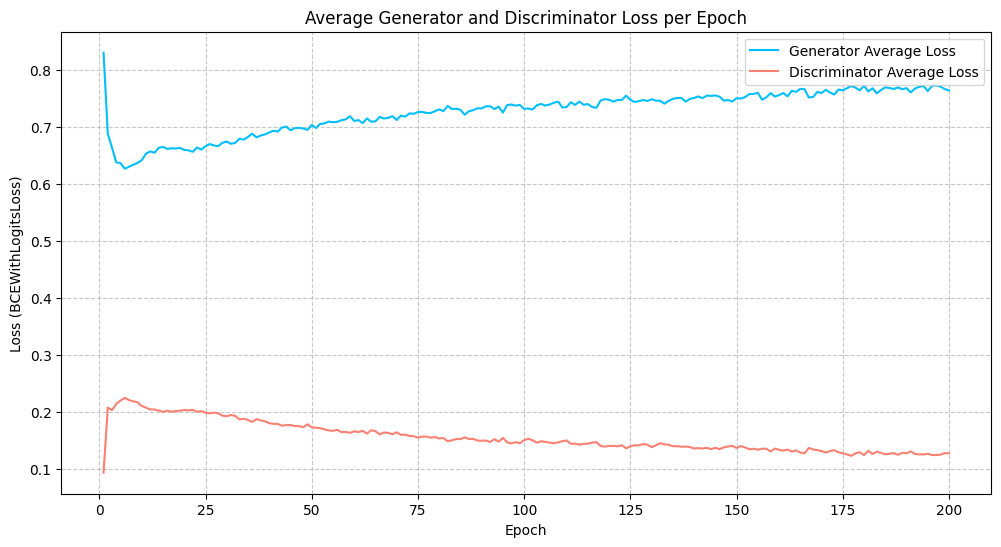

Accuracy graph saved to: plots\gan_accuracy_history.png


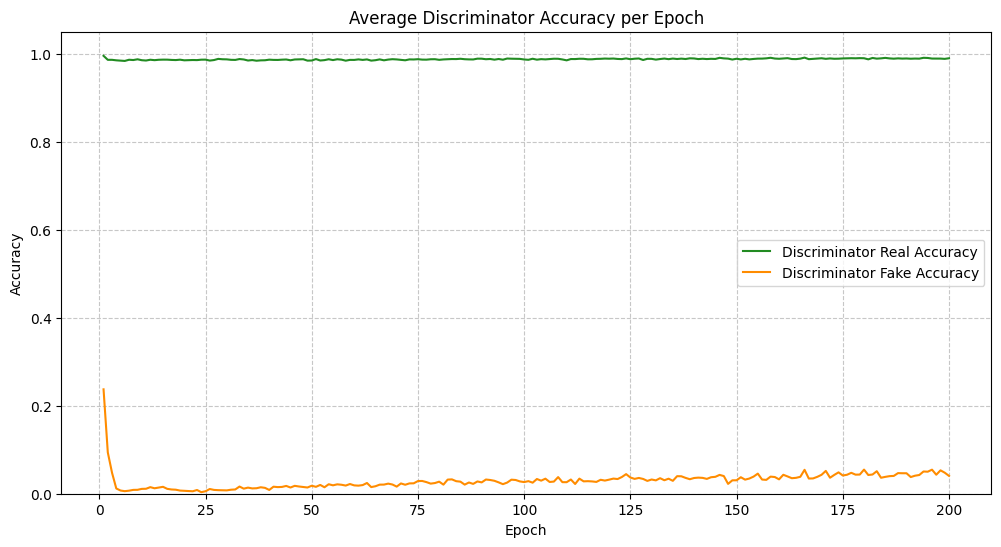

In [11]:
import matplotlib.pyplot as plt
import os

# --- Assume Training Loop Finished ---
# Make sure these lists exist and are populated correctly:
# d_loss_history = [...] # Avg D loss per epoch
# g_loss_history = [...] # Avg G loss per epoch
# d_real_acc_history = [...] # Avg D real accuracy per epoch
# d_fake_acc_history = [...] # Avg D fake accuracy per epoch

print("\nPlotting loss and accuracy history...")

# --- Directory for Plots ---
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

# --- Plot Losses ---
if d_loss_history and g_loss_history:
    epochs = range(1, len(d_loss_history) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, g_loss_history, label='Generator Average Loss', color='deepskyblue')
    plt.plot(epochs, d_loss_history, label='Discriminator Average Loss', color='salmon')
    plt.title('Average Generator and Discriminator Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCEWithLogitsLoss)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the loss plot
    loss_plot_filename = os.path.join(plot_dir, 'gan_loss_history.png')
    try:
        plt.savefig(loss_plot_filename)
        print(f"Loss graph saved to: {loss_plot_filename}")
    except Exception as e:
        print(f"Error saving loss graph: {e}")
    plt.show() # Optional: Show interactively
    plt.close() # Close the figure
else:
    print("Skipping loss plot (history lists missing or empty).")


# --- Plot Accuracies ---
# Make sure history lists for accuracy exist
if d_real_acc_history and d_fake_acc_history:    
    
    # Define epochs if not already defined (in case loss plot was skipped)
    if 'epochs' not in locals():
        epochs = range(1, len(d_real_acc_history) + 1)

    plt.figure(figsize=(12, 6))
    # Plot the ACTUAL accuracy histories
    plt.plot(epochs, d_real_acc_history, label='Discriminator Real Accuracy', color='forestgreen')
    plt.plot(epochs, d_fake_acc_history, label='Discriminator Fake Accuracy', color='darkorange')
    plt.title('Average Discriminator Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05) # Set Y-axis limits for accuracy (0 to 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the accuracy plot
    acc_plot_filename = os.path.join(plot_dir, 'gan_accuracy_history.png')
    try:
        plt.savefig(acc_plot_filename)
        print(f"Accuracy graph saved to: {acc_plot_filename}")
    except Exception as e:
        print(f"Error saving accuracy graph: {e}")
    plt.show() # Optional: Show interactively
    plt.close() # Close the figure
else:
    print("Skipping accuracy plot (history lists missing or empty).")

In [12]:
# Save the final model explicitly
save_name = "goodrun_c2_tanay"
save_path = os.path.join('models', f'{save_name}.pth')
os.makedirs('models', exist_ok=True)

# save the model weights

torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
}, save_path)
print(f"Final model saved to: {save_path}")

Final model saved to: models\goodrun_c2_tanay.pth


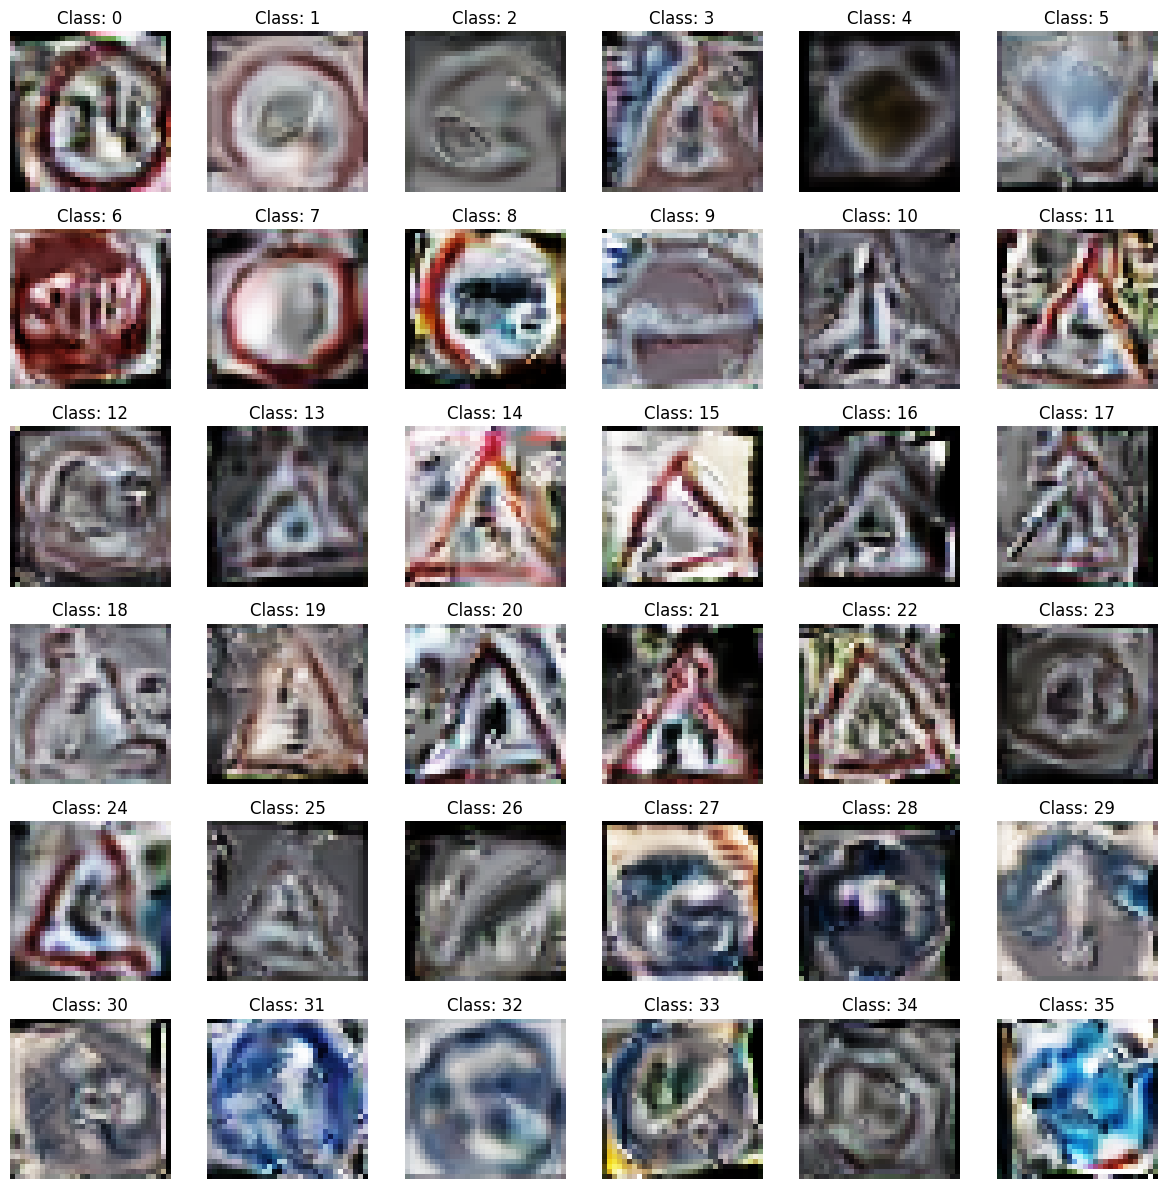

In [13]:
# Generate final samples
fake_samples, sample_labels = generate_samples(num_samples=36)
fig = create_image_grid(fake_samples, sample_labels, nrow=6)
fig.savefig('final_generated_samples_tanay.png')
plt.show()